# Numerical Project TFY4240 - Assignement 2

In this assignement we are looking at the aurora borealis and how the magnetic field of the earth can create this effect. To do this we are modelling the earth as a magnetic dipole and sending a charged particle from the sun at it.


In [2]:
# Imports used throughout the project

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## 1) Modelling the earth as a magnetic dipole

First we need to know the magnetic field around the earth, we can here use a simplification and model it as a magnetic dipole.

The magnetic field created by a dipole can be written as:

$$
B_{dip}(\vec{r}) = \frac{\mu_{0}}{4\pi}\frac{1}{r^3}[3(\vec{m}\cdot{\hat{r}})\hat{r}-\vec{m}]
$$

where r is the length of $\vec{r}$ and $\vec{m}$ is the magnetic dipole moment.

In the case of the earth, the magnitude of the magnetic diople is roughly $6.4\cdot 10^{22} Am^2$. This means we can write $\vec{m} = |{\vec{m}}| \hat{m}$, and now only need the direction of the magnetic moment. 

To find $\vec{\hat{m}}$ we first have to define our coordinate system. In this project we will have the x-axis pointing towards the the sun from the center of the earth, the z-axis will point straight up from the x-axis and the y-axis will go out of the screen. 
We then have to account for the tilt of the earth, and the fact that the magnetic north pole is not at the north pole. The eventual particle we will simulate should move so fast that we need not account for the rotation of the earth around the sun or its own axis. We will therefore choose a moment in time for which the north pole is tilted 23.5 degrees towards the sun, from the z-axis using spherical coordinates, and the magnetic north pole is 11 degrees towards the sun from the north pole again.
This means the angle of the magnetic moment will be $\theta = 34.5 °$ and in cartesian coordinates it will have only components in the z and x direction.

As $\vec{\hat{m}}$ has a magnitude of 1 we can write $\vec{m}$  as


$$
\vec{m} = |\vec{m}|\hat{m} = 6.4 \cdot 10^{22} (sin(34.5 °)\hat{x} + cos(34.5 °) \hat{z})
$$

Finally we can write the function for the B-field:

In [3]:
mu_0 = 1.2e-6
m = 6.4*10**22 * np.array([np.sin(np.radians(34.5)), 0, np.cos(np.radians(34.5))]) 


def get_B_field(pos): 
    r_vec = np.array(pos)
    r = np.linalg.norm(pos)
    r_hat = r_vec/r
    B_vec = mu_0/(4*np.pi) * (3 * ( np.dot(m,r_hat))*r_hat - m)/r**3
    return B_vec


We then plot the magnetic field in xy and xz plane.

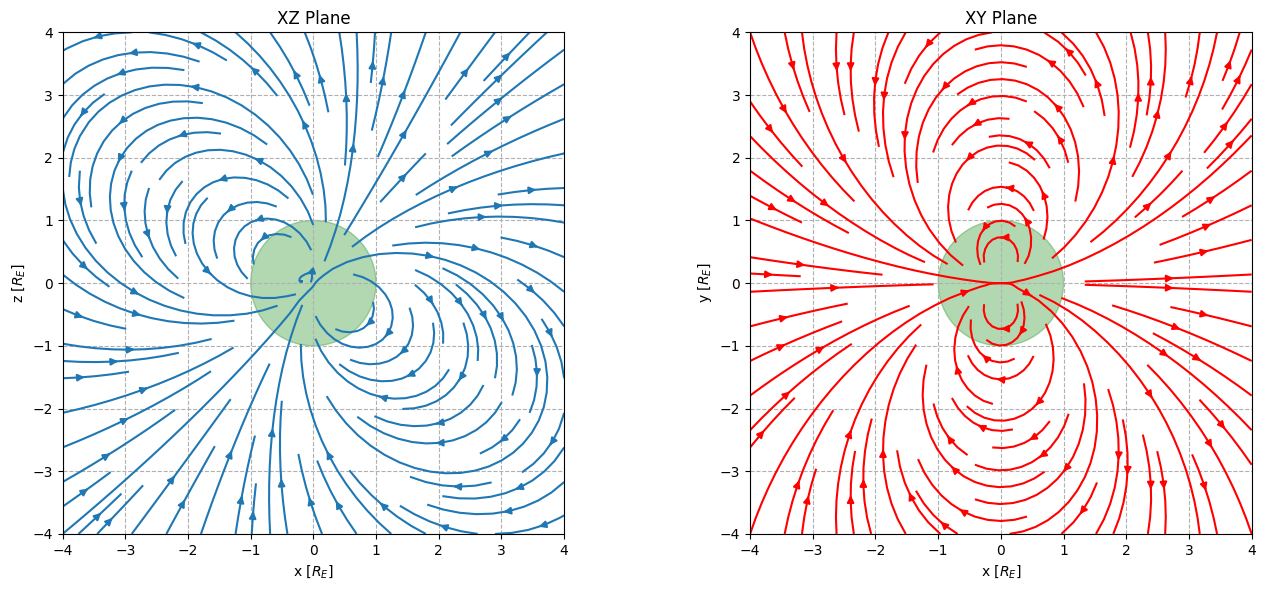

In [4]:
Re = 6371e3 # Using the earths radius to make the plots cleaner

limit = 4 * Re
points = 50
coords = np.linspace(-limit, limit, points)
X_grid, Z_grid = np.meshgrid(coords, coords)

Bx_xz = np.zeros_like(X_grid)
Bz_xz = np.zeros_like(Z_grid)

Bx_xy = np.zeros_like(X_grid)
By_xy = np.zeros_like(Z_grid)

# Calculate field at each point
for i in range(points):
    for j in range(points):
        b_xz = get_B_field(np.array([X_grid[i,j], 0, Z_grid[i,j]]))
        Bx_xz[i,j], Bz_xz[i,j] = b_xz[0], b_xz[2]
        
        b_xy = get_B_field(np.array([X_grid[i,j], Z_grid[i,j], 0]))
        Bx_xy[i,j], By_xy[i,j] = b_xy[0], b_xy[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# XZ Plane
ax1.streamplot(X_grid/Re, Z_grid/Re, Bx_xz, Bz_xz)
ax1.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3, label='Earth'))
ax1.set_title("XZ Plane")
ax1.set_xlabel("x [$R_E$]")
ax1.set_ylabel("z [$R_E$]")

# XY Plane 
ax2.streamplot(X_grid/Re, Z_grid/Re, Bx_xy, By_xy, color='red')
ax2.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3))
ax2.set_title("XY Plane")
ax2.set_xlabel("x [$R_E$]")
ax2.set_ylabel("y [$R_E$]")

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

## 2 and 3) Simulating the solar wind

We now take a look at solar wind as charged particles, more precisely looking at a proton traveling towards the earth at some initial speed.
To find its trajectory we use Implicit Eulers method. To use this we first need to know the acceleration the proton would experience.
This can be found through the Lorentz force.

$$
F = q v \times B
$$

where q is the charge of the particle, v is the speed and B is the magnetic field at its position.

Using Newtons second we can then find the acceleration

$$
a = q \frac{v \times B}{m_p}
$$



Implicit Euler tells us that in our case

$$
v_{n+1} = v_n + a(v_n) \cdot dt
$$
$$
r_{n+1} = r_n + v_{n+1} \cdot dt
$$

where r is the postion of the particle and dt is a small quantity.

This can then be made into a function:


In [ ]:
e = 1.6e-19
m_p = 1.67e-27

# Implicit Euler
def euler_solve_ivp(pos, v, dt):
    B = get_B_field(pos)
    a = e * np.cross(v, B) / m_p
    v_new = v + a * dt
    pos_new = pos + v_new * dt
    return pos_new, v_new



We then model the proton with initially constant velocity towards the earth on the x-axis. It starts ten earth radii away from the earth. To estimate the accuracy of the solution we need a test condition (see task 3). In our simulation only the magnetic force is acting on the proton, and the magnetic force should not do any work on the particle. This means energy should be constant, or equivalent in our case, meaning the speed of the particle is constant.

In [6]:
# Initial Conditions
pos = np.array([-10*Re, 0, 0]) 
v = np.array([400000, 0, 0])  
t_end = 100
dt = 0.00001
t_eval = np.arange(0,t_end,dt)
                  


trajectory = [pos]
speed = []

for t in t_eval:
    pos, v = euler_solve_ivp(pos, v, dt)

    trajectory.append(pos)

    speed.append(np.linalg.norm(v))

trajectory = np.array(trajectory)


First we check for energy conservation:

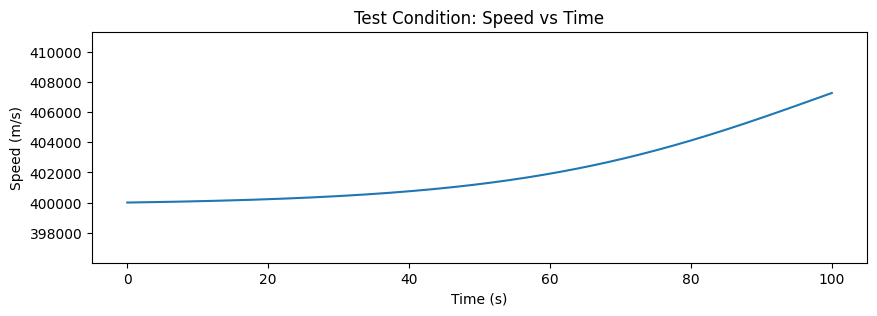

In [13]:
plt.figure(figsize=(10, 3))
plt.plot(t_eval, speed)
plt.title("Test Condition: Speed vs Time")
plt.ylabel("Speed (m/s)")
plt.xlabel("Time (s)")
plt.ylim(min(speed)*0.99, max(speed)*1.01)
plt.show()

We observe that the speed is not completley constant, but does not have a large change. To get a more accurate plot we could use a smaller time interval, lower speed, use a more stable solver or write more efficient code. Currently I think this is what will get us the most interesting plots with the method used.

## 4 and 5) Plotting the Trajectories

We then plot the trajectory in the XY, XZ and YZ plane as well as in 3D.


*I choose not to write the trajectories into a file as it is easier to manage them just in a list.*

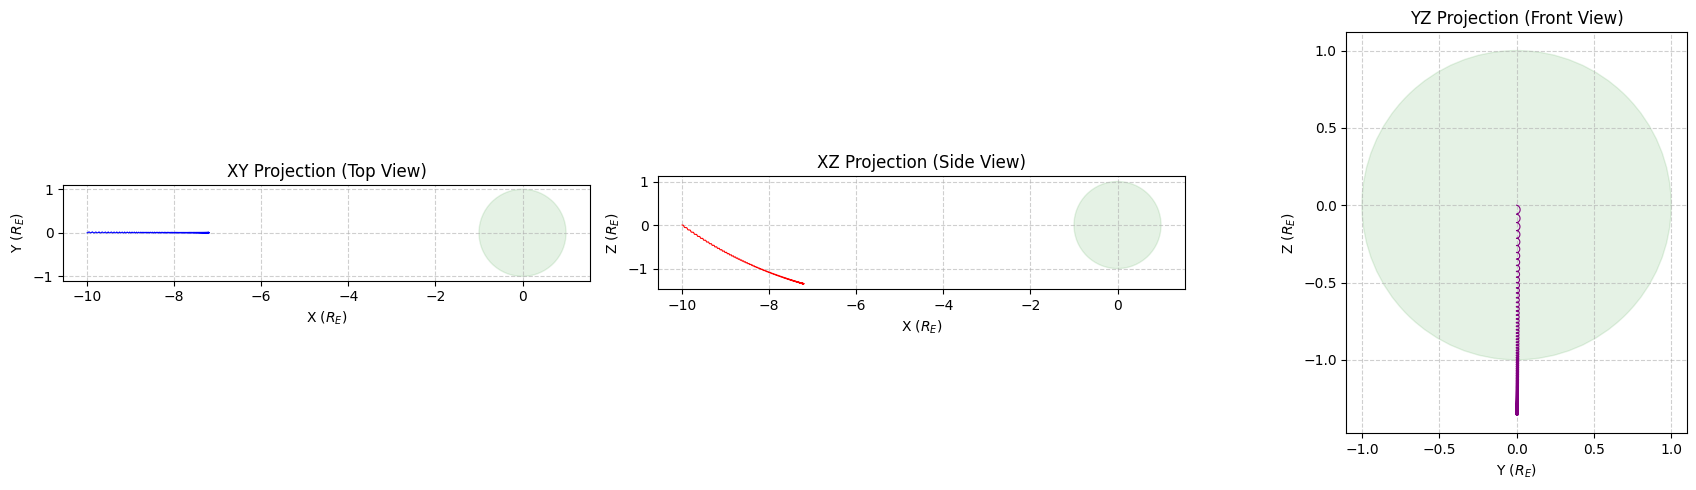

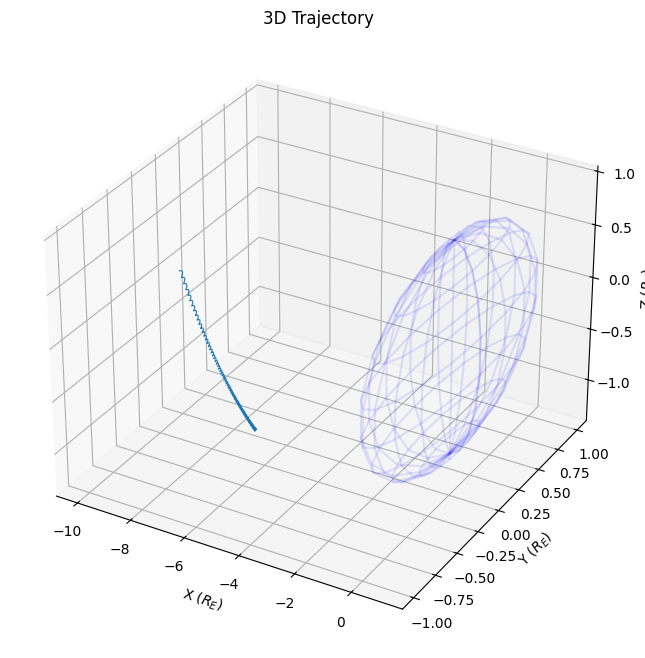

In [ ]:
pos_traj = trajectory[:, :3] / Re # Normalize to Earth Radii
x, y, z = pos_traj[:, 0], pos_traj[:, 1], pos_traj[:, 2]

fig2, axes = plt.subplots(1, 3, figsize=(18, 5))

# Earth for reference
def draw_earth(ax):
    circle = plt.Circle((0, 0), 1, color='green', alpha=0.1)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)

# XY-plane
axes[0].plot(x, y, lw=0.8, color='blue')
draw_earth(axes[0])
axes[0].set_title("XY Projection (Top View)")
axes[0].set_xlabel("X ($R_E$)")
axes[0].set_ylabel("Y ($R_E$)")

# XZ-plane
axes[1].plot(x, z, lw=0.8, color='red')
draw_earth(axes[1])
axes[1].set_title("XZ Projection (Side View)")
axes[1].set_xlabel("X ($R_E$)")
axes[1].set_ylabel("Z ($R_E$)")

# YZ-plane
axes[2].plot(y, z, lw=0.8, color='purple')
draw_earth(axes[2])
axes[2].set_title("YZ Projection (Front View)")
axes[2].set_xlabel("Y ($R_E$)")
axes[2].set_ylabel("Z ($R_E$)")

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.8, label="Proton Path")

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
xe = np.cos(u)*np.sin(v)
ye = np.sin(u)*np.sin(v)
ze = np.cos(v)
ax.plot_wireframe(xe, ye, ze, color="blue", alpha=0.1)

ax.set_xlabel("X ($R_E$)")
ax.set_ylabel("Y ($R_E$)")
ax.set_zlabel("Z ($R_E$)")
ax.set_title("3D Trajectory")
plt.show()


We observe a kind of spiraling movement as the proton is being repelled by the Earths magnetic field and finally have an explanation of the aurora borealis!